In [28]:
import pandas
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

import time
import datetime
import matplotlib.pyplot as plt

In [7]:
features = pandas.read_csv('./features.csv', index_col='match_id')
features.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16.0,2449,0,4,1974,3,63


# Градиентный бустинг в "лоб"

In [8]:
X = features.loc[:, 'lobby_type':'dire_first_ward_time']
y = features.radiant_win # Целевая переменная

In [9]:
# Признаки которые имеют пропуски
X.columns[X.isna().any()].tolist()

['first_blood_time',
 'first_blood_team',
 'first_blood_player1',
 'first_blood_player2',
 'radiant_bottle_time',
 'radiant_courier_time',
 'radiant_flying_courier_time',
 'radiant_first_ward_time',
 'dire_bottle_time',
 'dire_courier_time',
 'dire_flying_courier_time',
 'dire_first_ward_time']

* ***first_blood_time*** - Первой крови за первые 5 минут может и не быть.

* ***first_blood_player2*** - Даже если первая кровь была, она могла быть сделана без ассиста.

* ***dire_first_ward_time*** - Если команда за первые 5 минут не установила "наблюдателя", то данное поле не заполнено.

In [10]:
# Заменим пропуски на среднее.
na_columns = X.columns[X.isna().any()].tolist()
for na_column in na_columns:
    X[na_column].fillna(X[na_column].mean(), inplace=True)

In [22]:
# Функция рисования графиков
def draw_chart(x, y, label_x, label_y):
    plt.plot(x, y)
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plt.show()

# Функция обучения модели
def do_fit(X, y, parameters, model_type):
    cv = KFold(n_splits=5, shuffle=True, random_state=241)
    means = []
    
    for p in parameters:
        scores = []
        start_time = datetime.datetime.now()
        
        for train_index, test_index in cv.split(X):
            X_train = X.iloc[train_index]
            y_train = y.iloc[train_index]

            X_test = X.iloc[test_index]
            y_test = y.iloc[test_index]
            
            if model_type == 'gradient_boosting':
                parameter_name = 'n_estimators'
                model = GradientBoostingClassifier(n_estimators=p)
            elif model_type == 'logistic_regression':
                parameter_name = 'C'
                model = LogisticRegression(penalty='l2', C=p)
            else:
                raise ValueError('Wrong model_type')
                
            model.fit(X_train, y_train)
            
            predicts = model.predict_proba(X_test)[:, 1]
            scores.append(roc_auc_score(y_true=y_test, y_score=predicts))
        
        means.append(np.mean(scores))
            
        print('Time elapsed: ', datetime.datetime.now() - start_time)
        print(parameter_name, '=', p, ': ', round(np.mean(scores), 5))
        print('')
        
    return means, parameters

Time elapsed:  0:00:17.369409
n_estimators = 10 :  0.66453

Time elapsed:  0:00:31.265364
n_estimators = 20 :  0.6817

Time elapsed:  0:00:47.299663
n_estimators = 30 :  0.68918

Time elapsed:  0:01:10.535207
n_estimators = 40 :  0.69371

Time elapsed:  0:01:18.009184
n_estimators = 50 :  0.69698

Time elapsed:  0:01:28.959807
n_estimators = 60 :  0.69972

Time elapsed:  0:01:44.980513
n_estimators = 70 :  0.70203

Time elapsed:  0:01:57.112876
n_estimators = 80 :  0.70374



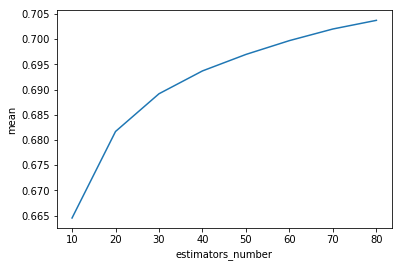

In [30]:
means, parameters = do_fit(X, y, [10, 20, 30, 40, 50, 60, 70, 80, 100, 200, 300], 'gradient_boosting')
draw_chart(parameters, means, 'estimators_number', 'mean')

При 30 деревьях качество 0.69. Расчеты длились 46 секунд.
Наилучшее качество получилось при 50 деревьях. Далее, при добавлении деревьев качество не улучшалось, а время расчетов быстро расло. Чтобы ускорить расчеты можно использовать меньшую выборку и установить ограничение на максимальную глубину деревьев.

## Логистическая регрессия

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [32]:
X = features.loc[:, 'lobby_type':'dire_first_ward_time']
y = features.radiant_win # Целевая переменная

In [33]:
# Заменим пропуски на среднее.
na_columns = X.columns[X.isna().any()].tolist()
for na_column in na_columns:
    X[na_column].fillna(X[na_column].mean(), inplace=True)

In [34]:
scaler = StandardScaler()
X_scaled = pandas.DataFrame(scaler.fit_transform(X))

Time elapsed:  0:00:07.189918
C = 0.001 :  0.71657

Time elapsed:  0:00:09.525911
C = 0.01 :  0.71669

Time elapsed:  0:00:09.719815
C = 0.1 :  0.71666

Time elapsed:  0:00:10.248192
C = 0.4 :  0.71666

Time elapsed:  0:00:10.267391
C = 0.8 :  0.71666

Time elapsed:  0:00:10.028837
C = 1.0 :  0.71666

Time elapsed:  0:00:10.102470
C = 1.5 :  0.71666

Time elapsed:  0:00:10.004721
C = 2.0 :  0.71666



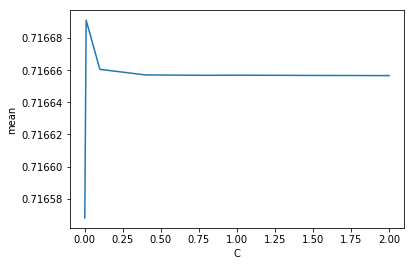

In [35]:
means, parameters = do_fit(X_scaled, y, [0.001, 0.01, 0.1, 0.4, 0.8, 1.0, 1.5, 2.0], 'logistic_regression')
draw_chart(parameters, means, 'C', 'mean')

In [41]:
max_score, best_c = max(zip(means, parameters))
print('Best C =', best_c)
print('Max Score =', round(max_score, 5))

Best C = 0.01
Max Score = 0.71669


Качество 0.71669 (при С = 0.01) - выше чем у градиентного бустинга в "лоб". Работает немного быстрее. Чем объяснить не знаю. Я ожидал что при градиентном бустинге качество будет выше. Видимо, такова особенность данных.

#### Удалим категориальные признаки

In [38]:
categorical_features = [
    'lobby_type', 
    'r1_hero', 
    'r2_hero',
    'r3_hero',
    'r4_hero',
    'r5_hero', 
    'd1_hero', 
    'd2_hero',
    'd3_hero',
    'd4_hero',
    'd5_hero'
]

In [39]:
X_scaled_no_categorical = pandas.DataFrame(
    scaler.fit_transform(X.drop(categorical_features, axis=1))
)

Time elapsed:  0:00:07.743050
C = 0.001 :  0.71657

Time elapsed:  0:00:09.658903
C = 0.01 :  0.71669

Time elapsed:  0:00:09.703632
C = 0.1 :  0.71666

Time elapsed:  0:00:09.762351
C = 0.4 :  0.71666

Time elapsed:  0:00:09.745854
C = 0.8 :  0.71666

Time elapsed:  0:00:09.804312
C = 1.0 :  0.71666

Time elapsed:  0:00:09.947705
C = 1.5 :  0.71666

Time elapsed:  0:00:09.911852
C = 2.0 :  0.71666



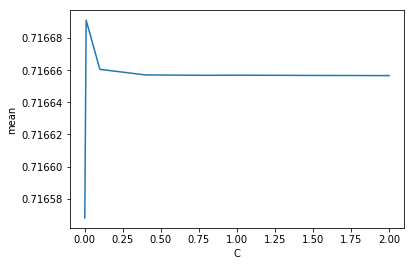

In [40]:
means, parameters = do_fit(X_scaled_no_categorical, y, [0.001, 0.01, 0.1, 0.4, 0.8, 1.0, 1.5, 2.0], 'logistic_regression')
draw_chart(parameters, means, 'C', 'mean')

In [42]:
max_score, best_c = max(zip(means, parameters))
print('Best C =', best_c)
print('Max Score =', round(max_score, 5))

Best C = 0.01
Max Score = 0.71669


##### При удалении категориальных признаков качество осталось прежним, . Я думаю это связано с тем что использование категориальных признаков как вещественных не имеет никакого смысло и не оказывает влияние на качество.

### "Мешок слов" для категориальных признаков

In [43]:
heroes = pandas.read_csv('./heroes.csv')
n_heroes = len(heroes)
print('Heroes number =', n_heroes)

Heroes number = 112


In [44]:
heroes.head()

,id,localized_name,name
0,1,Anti-Mage,antimage
1,2,Axe,axe
2,3,Bane,bane
3,4,Bloodseeker,bloodseeker
4,5,Crystal Maiden,crystal_maiden


In [47]:
X_heroes = np.zeros((features.shape[0], n_heroes))
for i, match_id in enumerate(features.index):
    for p in range(5):
        X_heroes[i, features.loc[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_heroes[i, features.loc[match_id, 'd%d_hero' % (p+1)]-1] = -1
        
X_heroes = pandas.DataFrame(X_heroes, index=features.index)

In [48]:
X_no_categorical = pandas.DataFrame(X.drop(categorical_features, axis=1))

final_x = pandas.concat([X_no_categorical, X_heroes], axis=1)
final_scaled_x =  pandas.DataFrame(scaler.fit_transform(final_x))

Time elapsed:  0:00:11.975266
C = 0.001 :  0.75171

Time elapsed:  0:00:16.457604
C = 0.01 :  0.75199

Time elapsed:  0:00:19.198561
C = 0.1 :  0.75195

Time elapsed:  0:00:19.282452
C = 0.4 :  0.75194

Time elapsed:  0:00:20.269587
C = 0.8 :  0.75194

Time elapsed:  0:00:19.208160
C = 1.0 :  0.75194

Time elapsed:  0:00:21.677570
C = 1.5 :  0.75194

Time elapsed:  0:00:24.712326
C = 2.0 :  0.75194



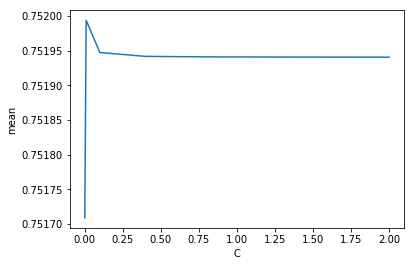

In [49]:
means, parameters = do_fit(final_scaled_x, y, [0.001, 0.01, 0.1, 0.4, 0.8, 1.0, 1.5, 2.0], 'logistic_regression')
draw_chart(parameters, means, 'C', 'mean')

In [50]:
max_score, best_c = max(zip(means, parameters))
print('Best C =', best_c)
print('Max Score =', round(max_score, 5))

Best C = 0.01
Max Score = 0.75199


При добавлении мешка слов по героям значение оценки качесва классификации заметно улучшилось. Это связано с тем, что теперь мы используем категориальные признаки более разумно, т. к. герои имеют разные характеристики, и некоторые из них выигрывают чаще, чем другие. Наилучшего качества логистическая регрессия с мешком слов по героям достигает при параметре регуляризации C = 0.01, при этом оценка качества составляет 0.75199.

### Проверка на тестовых данных

In [67]:
# Подготовка тестовых данных
features_test = pandas.read_csv('features_test.csv', index_col='match_id')

X_test = features_test.loc[:, 'lobby_type':'dire_first_ward_time']

na_columns = X_test.columns[X_test.isna().any()].tolist()
for na_column in na_columns:
    X_test[na_column].fillna(X_test[na_column].mean(), inplace=True)
    
X_test_no_categorical = X_test.drop(categorical_features, axis=1)

X_heroes = np.zeros((features_test.shape[0], n_heroes))
for i, match_id in enumerate(features_test.index):
    for p in range(5):
        X_heroes[i, features_test.loc[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_heroes[i, features_test.loc[match_id, 'd%d_hero' % (p+1)]-1] = -1
        
X_heroes = pandas.DataFrame(X_heroes, index=features_test.index)

final_X_test = pandas.concat([X_test_no_categorical, X_heroes], axis=1)
final_scaled_X_test =  pandas.DataFrame(scaler.fit_transform(final_X_test))

In [69]:
model = LogisticRegression(C=0.01, random_state=241)
model.fit(final_scaled_x, y)
y_test = model.predict_proba(final_scaled_X_test)
p = list(map(lambda v: max(v), y_test))

In [71]:
max(p)

0.9965010070400059

In [72]:
min(p)

0.5000333853546345

Предсказанные вероятности адекватные — находятся на отрезке [0, 1], не совпадают между собой.